# Data cleaning for tabular clinical data

**Key functions we will use:**
- `pd.read_csv()` → load data from CSV files into a DataFrame.
- `.head()` → view the first rows of a DataFrame.
- `.info()` → summary of the DataFrame (columns, types, missing values).
- `.describe()` → summary statistics for numeric/categorical columns.
- `.isna()` / `.isnull()` → identify missing values.
- `.replace()` → replace values in the DataFrame.
- `.drop_duplicates()` → remove duplicate rows.
- `.dropna()` → remove missing values.
- `.astype()` → convert column types.
- `.merge()` → join two DataFrames.
- `.plot()` / `matplotlib` / `seaborn` → visualize data.

## 1 Import libraries

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [381]:
patients = pd.read_csv('data/patients.csv')
labs = pd.read_csv('data/lab_data.csv')

In [382]:
# show first few rows
patients.head()

,patient_id,age,admission_date,discharge_date,gender,weight,height,blood_pressure,admission_unit
0,1,39.0,2023-01-05,2023-01-10,f,78.0,184.0,130.0,Surgery
1,2,60.0,2023-02-11,2023-02-20,m,55.0,180.0,90.0,Cardiol.
2,3,18.0,2023-03-01,2023-03-10,female,80.0,250.0,90.0,Surgery
3,4,50.0,2023-03-20,2023-03-25,f,70.0,179.0,110.0,Intensive Care U.
4,5,39.0,2023-04-15,2023-04-20,m,55.0,NaN,110.0,Intensive Care U.


In [383]:
# show labs data
labs.head()

,patient_id,albumin_g_dl
0,44,NaN
1,29,3.0
2,35,4.5
3,7,5.0
4,26,4.3


## 2 Joining datasets

- Use `pd.merge()` to combine datasets on a key (`patient_id`)
- `how='left'` keeps all patient rows and adds lab values if available
- (Use `how='inner'` to keep only rows present in both tables or `how='outer'` to keep all rows from both tables)

In [384]:
# merge patients with labs
patients = pd.merge(patients, labs, on='patient_id', how='left')

In [385]:
# show first few rows after merge
patients.head()

,patient_id,age,admission_date,discharge_date,gender,weight,height,blood_pressure,admission_unit,albumin_g_dl
0,1,39.0,2023-01-05,2023-01-10,f,78.0,184.0,130.0,Surgery,1.0
1,2,60.0,2023-02-11,2023-02-20,m,55.0,180.0,90.0,Cardiol.,NaN
2,3,18.0,2023-03-01,2023-03-10,female,80.0,250.0,90.0,Surgery,10.0
3,4,50.0,2023-03-20,2023-03-25,f,70.0,179.0,110.0,Intensive Care U.,3.1
4,5,39.0,2023-04-15,2023-04-20,m,55.0,NaN,110.0,Intensive Care U.,3.1


## 2 Quick exploration: `.info()` and `.describe()`

- `df.info()` shows column names, data types, and non-null counts. It's the fastest way to spot missing values and wrong dtypes
- `df.describe(include='all')` gives summary statistics for numeric and non-numeric columns

In [386]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      58 non-null     int64  
 1   age             54 non-null     float64
 2   admission_date  57 non-null     object 
 3   discharge_date  57 non-null     object 
 4   gender          58 non-null     object 
 5   weight          57 non-null     float64
 6   height          49 non-null     float64
 7   blood_pressure  54 non-null     float64
 8   admission_unit  56 non-null     object 
 9   albumin_g_dl    44 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 4.7+ KB


In [387]:
patients.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patient_id,58.0,NaN,NaN,NaN,28.603448,16.726845,1.0,14.25,28.5,42.75,57.0
age,54.0,NaN,NaN,NaN,52.814815,20.173843,18.0,39.0,54.0,62.0,90.0
admission_date,57,28,2023-05-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_date,57,28,2023-05-05,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,58,4,male,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,57.0,NaN,NaN,NaN,111.122807,119.399999,45.0,65.0,75.0,85.0,500.0
height,49.0,NaN,NaN,NaN,187.469388,44.616468,159.0,165.0,172.0,179.0,300.0
blood_pressure,54.0,NaN,NaN,NaN,157.777778,119.019844,60.0,80.0,105.0,237.5,500.0
admission_unit,56,10,Intensive Care U.,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
albumin_g_dl,44.0,NaN,NaN,NaN,4.884091,2.227309,1.0,3.5,4.5,5.0,10.0


## 3 Converting columns to correct data types

- Numeric columns stored as strings prevent calculations. We use `pd.to_numeric(..., errors='coerce')` to convert values to numbers; invalid parses become NaN (so we can handle them deliberately).
- Date columns are converted with `pd.to_datetime(..., errors='coerce')` so we can do date arithmetic.
- Categorical variables can be cast to `'category'` dtype to save memory and make operations explicit.

We'll convert `age`, `height` to numeric, and attempt to parse admission/discharge dates.

In [388]:
# Convert 'age' to int64
patients['age'] = pd.to_numeric(patients['age'], errors='coerce').astype('Int64')

# Convert dates to datetime
patients['admission_date'] = pd.to_datetime(patients['admission_date'], errors='coerce')
patients['discharge_date'] = pd.to_datetime(patients['discharge_date'], errors='coerce')

In [389]:
# Show dtypes after conversion
patients.dtypes

patient_id                 int64
age                        Int64
admission_date    datetime64[ns]
discharge_date    datetime64[ns]
gender                    object
weight                   float64
height                   float64
blood_pressure           float64
admission_unit            object
albumin_g_dl             float64
dtype: object

## 4 Visualizing distributions

- Visualizing numeric columns helps spot outliers and understand distributions.
- We can use barplots and boxplots.
- We focus on `weight`, `blood_pressure`, and `age` here.

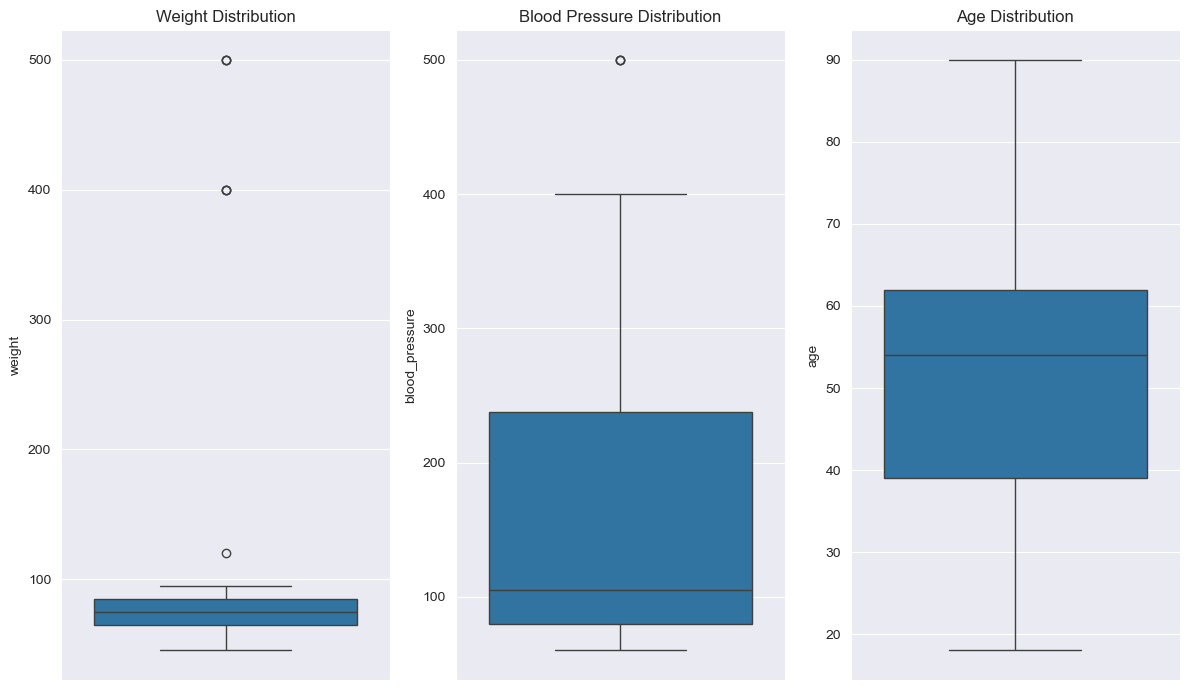

In [390]:
# Boxplots for numeric columns to spot outliers for weight, blood_pressure in separate plots
plt.figure(figsize=(12,7))
plt.subplot(1,3,1)
sns.boxplot(y=patients['weight'])
plt.title('Weight Distribution')
plt.subplot(1,3,2)
sns.boxplot(y=patients['blood_pressure'])
plt.title('Blood Pressure Distribution')
plt.subplot(1,3,3)
sns.boxplot(y=patients['age'])
plt.title('Age Distribution')
plt.tight_layout()
plt.show()

## 5 Handling outliers

- Outliers should be inspected: are they data entry mistakes or true extreme clinical cases?
- For obvious errors (e.g., weight = 500 kg or height = 300 cm), we may drop or cap them. Here we show a conservative filters example to remove implausible values.
- The more data-driven IQR method adapts to the actual distribution. We will apply both methods.

In [391]:
# Count rows before filtering
before = len(patients)

#### Example conservative filtering: remove implausible physiological values

- Height: keep between 100 cm and 250 cm
- Blood pressure: keep between 40 mmHg and 250 mmHg
- We allow NaNs to remain for now (will handle missingness later)

In [392]:
patients = patients[(patients['height'].isna()) | ((patients['height'] > 100) & (patients['height'] < 250))]
patients = patients[(patients['blood_pressure'].isna()) | ((patients['blood_pressure'] > 40) & (patients['blood_pressure'] < 250))]

#### Example IQR-based filtering for weight

- Calculate Q1, Q3, and IQR for weight
- Define lower and upper bounds as Q1 - 1.5*IQR and Q3 + 1.5*IQR
- Filter rows outside these bounds
- This method is more data-driven and adapts to the actual distribution
- We allow NaNs to remain for now (will handle missingness later)

In [393]:
Q1 = patients['weight'].quantile(0.25)
Q3 = patients['weight'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
patients = patients[((patients['weight'] >= lower_bound) & (patients['weight'] <= upper_bound))]

In [394]:
# Count rows after filtering and print both counts
after = len(patients)
print(f"Rows before: {before}, after outlier filter: {after}")

Rows before: 58, after outlier filter: 33


## 6 Detect missing values

Real-world datasets contain often missing values. We count missing values per column to understand the extent of missingness. Afterwards we will handle them appropriately (depending on the analysis, we may drop rows, impute values, or flag missingness).

In [395]:
# Show missing counts per column
patients.isna().sum()

patient_id         0
age                2
admission_date     0
discharge_date     0
gender             0
weight             0
height             7
blood_pressure     3
admission_unit     0
albumin_g_dl      12
dtype: int64

#### Method 1: Drop rows with missing values in critical columns (e.g., admission_date, discharge_date)

In [396]:
# Drop rows missing admission or discharge dates
patients = patients.dropna(subset=['admission_date', 'discharge_date', 'height'])

#### Method 2: Impute missing data (e.g., blood_pressure) with mean

In [397]:
# Impute missing blood_pressure with mean
mean_bp = patients['blood_pressure'].mean()
patients['blood_pressure'] = patients['blood_pressure'].fillna(mean_bp)

# Impute albumin_g_dl with mean
mean_albumin = patients['albumin_g_dl'].mean()
patients['albumin_g_dl'] = patients['albumin_g_dl'].fillna(mean_albumin)

In [398]:
# Show missing counts per column
patients.isna().sum()

patient_id        0
age               2
admission_date    0
discharge_date    0
gender            0
weight            0
height            0
blood_pressure    0
admission_unit    0
albumin_g_dl      0
dtype: int64

## 7 Detecting and removing duplicates

- Duplicates (identical rows) can inflate counts and bias results. Use `df.duplicated()` to detect and `df.drop_duplicates()` to remove.
- If duplicates are partial (same patient with different timestamps), domain knowledge is required to deduplicate safely.

In [399]:
# Count duplicate rows (exact duplicates)
dup_count = patients.duplicated().sum()
print("Exact duplicate rows:", dup_count)

# Example: show duplicates if any (first few)
if dup_count > 0:
    display(patients[patients.duplicated(keep=False)].head())

# Remove exact duplicates
patients = patients.drop_duplicates()

Exact duplicate rows: 0


### Save cleaned dataset

In [400]:
# Save cleaned data to new CSV
patients.to_csv('data/patients_cleaned.csv', index=False)

## 8 Exercise — Data Cleaning

Please complete the following tasks:

1. Handle outliers in `age` by setting rows where age is less than 18 and more than 100 to NaN.
2. Count how many patients have missing values in `age`.
3. Impute missing `age` values with the median age. (use `.median()`)
4. Plot the `age` distribution after cleaning and briefly interpret whether values look plausible.